# 🧠 Phase 4. 모델링 (Modeling) Random Forest

앞선 단계에서 생성한 파생 변수(Feature)들이 포함된 데이터를 불러와 본격적인 모델 학습을 진행합니다.

### 📋 진행 순서
1.  **데이터 로드:** `data_preprocess` 폴더에 저장해둔 학습/테스트 데이터 로드.
2.  **인코딩 (Encoding):** 컴퓨터가 이해할 수 있도록 문자열 데이터(`type_name` 등)를 숫자로 변환.
3.  **학습 및 검증 (Train & Val):** 모델을 학습시키고, 검증 데이터로 성능(RMSE) 평가.
4.  **최종 예측 (Inference):** 테스트 데이터에 대한 결과를 예측하고 제출 파일 생성.

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

# 1. 경로 설정
PREPROCESS_DIR = './data_preprocess'
SUBMISSION_DIR = './open_track1' # 샘플 제출 양식 있는 곳

TRAIN_PATH = os.path.join(PREPROCESS_DIR, 'train_enriched.csv')
TEST_PATH = os.path.join(PREPROCESS_DIR, 'test_enriched.csv')
SUBMISSION_PATH = os.path.join(SUBMISSION_DIR, 'sample_submission.csv')

# 2. 데이터 로드
print("⏳ 가공된 데이터 로딩 중...")
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"✅ Train Data: {train_df.shape}")
print(f"✅ Test Data: {test_df.shape}")

display(train_df.head(3))

⏳ 가공된 데이터 로딩 중...
✅ Train Data: (15435, 21)
✅ Test Data: (2414, 12)


,game_id,period_id,episode_id,time_seconds,team_id,player_id,action_id,type_name,result_name,start_x,...,end_x,end_y,is_home,game_episode,prev_type_name,prev_end_x,prev_end_y,dist_to_goal,angle_to_goal,dist_to_center
0,126283,1,1,124.367,2354,500146,68,Pass,Successful,101.054205,...,97.134030,41.793072,True,126283_1,Carry,101.054205,52.757324,19.167851,-78.120454,52.051398
1,126283,1,3,194.067,2354,344559,84,Pass,Unsuccessful,100.221660,...,95.927160,0.237320,True,126283_3,Carry,100.221660,0.066028,34.268747,81.984716,58.556565
2,126283,1,4,215.033,4639,77845,96,Pass,Unsuccessful,5.457847,...,7.246953,66.122064,False,126283_4,Interception,4.435830,64.031500,104.664891,-18.000132,57.088208


In [2]:
print("🔄 데이터 인코딩 및 피처 정리 중...")

# 1. 인코딩할 범주형 변수 목록
cat_features = ['type_name', 'prev_type_name']

# 2. Label Encoding 적용
le = LabelEncoder()

for col in cat_features:
    # Train과 Test의 모든 값을 합쳐서 학습 (새로운 라벨 대응)
    # 문자열로 변환하여 NaN 값 처리 방지
    all_values = pd.concat([train_df[col].astype(str), test_df[col].astype(str)]).unique()
    le.fit(all_values)
    
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# 3. 학습에 사용할 피처 선택
# 모델이 학습할 정보 (X)
feature_cols = [
    'start_x', 'start_y',             # 기본 좌표
    'type_name', 'team_id',           # 행동 정보
    'time_seconds',                   # 시간 정보
    'prev_type_name', 'prev_end_x', 'prev_end_y', # ⭐ 직전 행동 정보 (Lag)
    'dist_to_goal', 'angle_to_goal', 'dist_to_center' # ⭐ 기하학적 정보 (Geometry)
]

# 정답 (y)
target_cols = ['end_x', 'end_y']

# 4. 입력(X)과 정답(y) 분리
X_train = train_df[feature_cols]
y_train = train_df[target_cols]

# 테스트 데이터 (ID 제외하고 피처만 선택)
X_test = test_df[feature_cols]
test_ids = test_df['game_episode']

print(f"📌 학습 피처 개수: {len(feature_cols)}개")
print(f"   - {feature_cols}")
display(X_train.head())

🔄 데이터 인코딩 및 피처 정리 중...
📌 학습 피처 개수: 11개
   - ['start_x', 'start_y', 'type_name', 'team_id', 'time_seconds', 'prev_type_name', 'prev_end_x', 'prev_end_y', 'dist_to_goal', 'angle_to_goal', 'dist_to_center']


,start_x,start_y,type_name,team_id,time_seconds,prev_type_name,prev_end_x,prev_end_y,dist_to_goal,angle_to_goal,dist_to_center
0,101.054205,52.757324,0,2354,124.367,0,101.054205,52.757324,19.167851,-78.120454,52.051398
1,100.221660,0.066028,0,2354,194.067,0,100.221660,0.066028,34.268747,81.984716,58.556565
2,5.457847,66.343459,0,4639,215.033,6,4.435830,64.031500,104.664891,-18.000132,57.088208
3,60.171825,2.108816,0,2354,227.733,11,80.492370,0.000000,55.014661,35.428404,32.800983
4,33.185670,26.107444,0,2354,255.767,12,72.033465,41.392348,72.246733,6.271764,20.864702


🤖 모델 학습 및 성능 검증 중 (RandomForest)...
📊 [검증 결과] RMSE
   - X축 오차: 13.2771
   - Y축 오차: 14.7229
   ⭐ 평균 RMSE: 14.0000


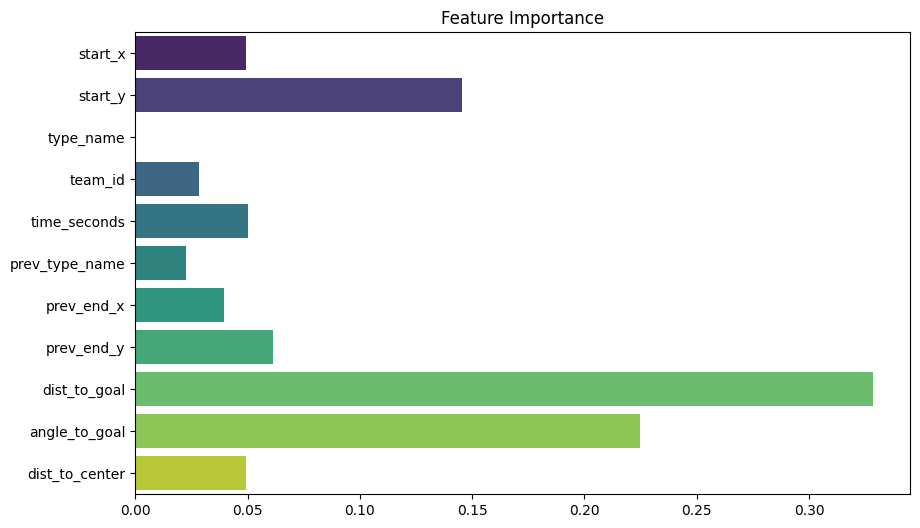

In [3]:
print("🤖 모델 학습 및 성능 검증 중 (RandomForest)...")

# 1. 검증용 데이터 분리 (Train 80% : Val 20%)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 2. 모델 정의 및 학습
# n_estimators: 나무의 개수 (많을수록 좋지만 느림)
# n_jobs=-1: 모든 CPU 코어 사용
model = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
model.fit(X_tr, y_tr)

# 3. 예측 및 점수 계산 (RMSE)
val_preds = model.predict(X_val)

rmse_x = np.sqrt(mean_squared_error(y_val['end_x'], val_preds[:, 0]))
rmse_y = np.sqrt(mean_squared_error(y_val['end_y'], val_preds[:, 1]))
mean_rmse = (rmse_x + rmse_y) / 2

print(f"📊 [검증 결과] RMSE")
print(f"   - X축 오차: {rmse_x:.4f}")
print(f"   - Y축 오차: {rmse_y:.4f}")
print(f"   ⭐ 평균 RMSE: {mean_rmse:.4f}")

# 4. 피처 중요도 확인 (어떤 변수가 가장 도움이 됐을까?)
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=model.feature_importances_, y=feature_cols, palette='viridis')
plt.title('Feature Importance')
plt.show()

In [4]:
print("🚀 전체 데이터로 재학습 및 제출 파일 생성 중...")

# 1. 전체 데이터로 다시 학습 (최고 성능을 위해)
model.fit(X_train, y_train)

# 2. 테스트 데이터 예측
predictions = model.predict(X_test)

# 3. 예측값 보정 (경기장 규격 0~105, 0~68)
pred_x = np.clip(predictions[:, 0], 0, 105)
pred_y = np.clip(predictions[:, 1], 0, 68)

# 4. 제출 포맷 만들기
submission_df = pd.DataFrame({
    'game_episode': test_ids,
    'end_x': pred_x,
    'end_y': pred_y
})

# 5. 샘플 제출 양식에 병합 (순서 보장)
sample_submission = pd.read_csv(SUBMISSION_PATH)
final_submission = pd.merge(sample_submission[['game_episode']], submission_df, on='game_episode', how='left')

# 결측치 채우기 (혹시 모를 안전장치)
final_submission.fillna(50.0, inplace=True)

# 6. 저장
save_filename = 'submission_with_features.csv'
final_submission.to_csv(save_filename, index=False)

print(f"🎉 저장 완료! 파일명: {save_filename}")

🚀 전체 데이터로 재학습 및 제출 파일 생성 중...
🎉 저장 완료! 파일명: submission_with_features.csv


데이터 로드 & 준비:

data_preprocess 폴더에 저장해둔 학습용/테스트용 데이터를 불러왔습니다.

이제 복잡한 전처리 과정 없이 이 파일들만 있으면 언제든 바로 모델링을 시작할 수 있습니다.

데이터 인코딩 (Encoding):

컴퓨터는 'Pass', 'Shot' 같은 글자를 이해하지 못합니다.

LabelEncoder를 사용해 이런 문자열 데이터(type_name, prev_type_name)를 숫자(0, 1, 2...)로 변환해 주었습니다.

모델 학습 및 검증 (Training & Validation):

알고리즘: RandomForestRegressor (랜덤 포레스트 회귀 모델)를 사용했습니다.

학습: 데이터를 8:2로 나누어 80%로 공부시키고, 나머지 20%로 시험을 쳐서 성능(RMSE 점수)을 확인했습니다.

중요도 확인: 우리가 만든 변수들(prev_~, dist_to_goal 등)이 실제로 예측에 얼마나 도움이 되었는지 그래프로 확인했습니다.

최종 예측 및 제출 파일 생성:

검증이 끝난 후, 전체 데이터를 사용하여 모델을 다시 학습시켰습니다(최고 성능을 위해).

테스트 데이터를 예측하고, 경기장 밖으로 나간 값들을 보정(Clipping)했습니다.

최종 결과물인 submission_with_features.csv 파일을 생성했습니다.